In [1]:
import numpy as np
from matplotlib import pyplot as plt
from my_utils import *
from sigproc_kit import *
import random
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
from numpy.fft import fft

from IPython.display import display, Math, Latex

def dB(x):
    return 20*np.log10(x)

$$e_n = \sqrt{4k_BTR} \left[\frac{V}{\sqrt{Hz}}\right]$$
$$i_n = \frac{e_n}{R} = \sqrt{4k_BT/R} \left[\frac{A}{\sqrt{Hz}}\right]$$
$$v_{noise}(rms) = e_n  \sqrt{\Delta f}$$
$$i_{noise}(rms) = v_{noise}(rms)/R $$

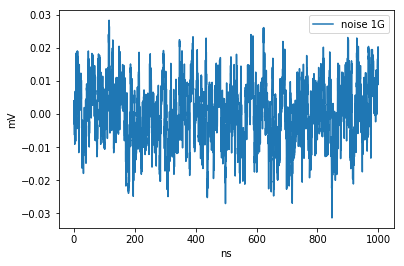

rms : 0.009 mV


In [2]:
t = np.arange(0,1000e-9,100e-12) 

##################################################
##             johnson noise model              ##
##################################################


R = 50
k_B = 1.380649e-23
T  = 300 # K
e_n = np.sqrt(4*k_B*T*R)

noise_bw = .1e9
noise_rms = e_n * np.sqrt(noise_bw)





y = add_noise(t,t*0,rms=noise_rms,bw=noise_bw)



plt.plot(t*1e9,y*1e3,label="noise 1G")

plt.xlabel("ns")
plt.ylabel("mV")
plt.legend()
plt.show()


print("rms : {:3.3f} mV".format(np.std(y)*1e3))

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


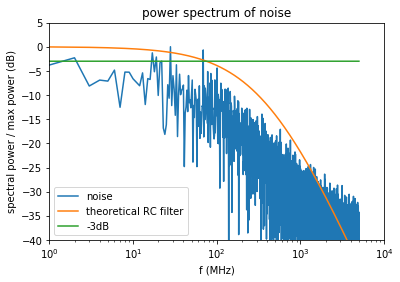

In [3]:
##################################################
##           power spectrum of noise            ##
##################################################

N = len(t)
T = t[1] -t[0]

yf = fft(y/1e-2)
yf = 2.0/N * np.abs(yf[0:N//2])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

noise_RC = 1/(4*noise_bw)

plt.plot(xf/1e6, dB(yf/np.max(yf)) ,label="noise" )

plt.plot(xf/1e6, 2*dB( 1/(1+xf*noise_RC)),label="theoretical RC filter" )
plt.plot(xf/1e6,xf*0-3,label="-3dB")

plt.xlabel("f (MHz)")
plt.xscale("log")
plt.ylabel("spectral power / max power (dB)")
plt.ylim(-40,5)
plt.title("power spectrum of noise")
plt.xlim(0,10000)
plt.legend()
plt.show()

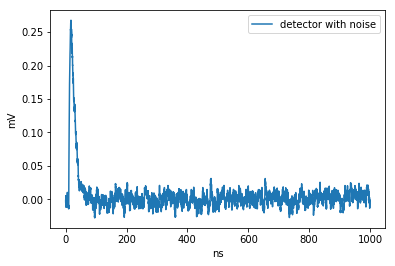

In [4]:
##################################################
##    detector pulse with 50R thermal noise     ##
##################################################



Q = 0.1e-12
tau1 = 5e-9
tau2 = 10e-9
delay = 10e-9

det = detector_signal_function(t, Q, tau1, tau2, delay)
det = add_noise(t,det,rms=noise_rms,bw=noise_bw)

plt.plot(t*1e9,det*1e3,label="detector with noise")

plt.xlabel("ns")
plt.ylabel("mV")
plt.legend()
plt.show()

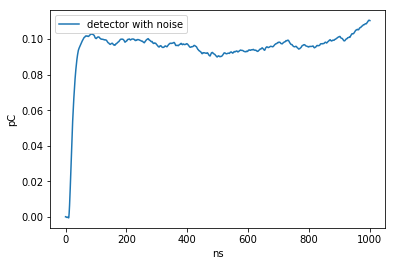

In [5]:
##################################################
##         integrate current to charge          ##
##################################################

# integrate current = voltage/50R
det_int = integrate_dt(t,det/50)

plt.plot(t*1e9,det_int*1e12,label="detector with noise")

plt.xlabel("ns")
plt.ylabel("pC")
plt.legend()
plt.show()

std at 500 ns: 0.009 pC
std at 900 ns: 0.013 pC


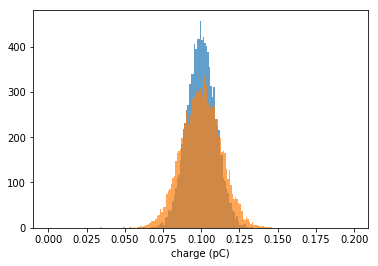

In [6]:
##################################################
##     integral of 1000 pulses after 500 ns     ##
##################################################
Q = 0.1e-12
tau1 = 5e-9
tau2 = 10e-9
delay = 10e-9

det_clean = detector_signal_function(t, Q, tau1, tau2, delay)

mQ500 = []
mQ900 = []

dt = t[1]-t[0]

index_500ns = int(500e-9/dt)
index_900ns = int(900e-9/dt)

for i in range(0,10000):
    
  det = add_noise(t,det_clean,rms=noise_rms,bw=noise_bw)
  
  
  # integrate current = voltage/50R
  det_int = integrate_dt(t,det/50)
  mQ500 += [det_int[index_500ns]]
  mQ900 += [det_int[index_900ns]]
  

mQ500 = np.array(mQ500)
mQ900 = np.array(mQ900)

bins = np.arange(0.0,0.2,0.001)
plt.hist(mQ500*1e12,alpha=0.7,bins=bins)
plt.hist(mQ900*1e12,alpha=0.7,bins=bins)
plt.xlabel("charge (pC)")

print("std at 500 ns: {:3.3f} pC".format(np.std(mQ500)*1e12))
print("std at 900 ns: {:3.3f} pC".format(np.std(mQ900)*1e12))

#print("the integral is independent of the noise bandwidth! (wrong!)")
# eeehr what?

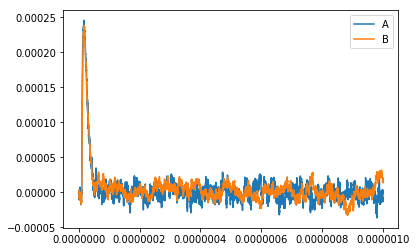

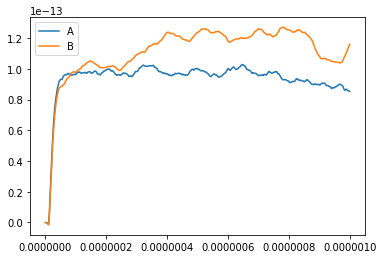

std a at 500 ns: 0.009 pC
std b at 500 ns: 0.016 pC
if the RMS is kept constant, low frequency noise hurts the integral more


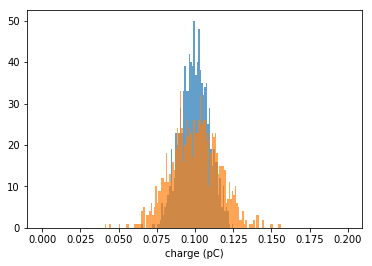

In [7]:
##################################################
##     integral of 1000 pulses after 500 ns     ##
##################################################
Q = 0.1e-12
tau1 = 5e-9
tau2 = 10e-9
delay = 10e-9

det_clean = detector_signal_function(t, Q, tau1, tau2, delay)

mQ500_a = []
mQ500_b = []

noise_bw_a = 100e6
noise_bw_b = 30e6

dt = t[1]-t[0]

index_500ns = int(500e-9/dt)

for i in range(0,1000):
    
  det_a = add_noise(t,det_clean,rms=noise_rms,bw=noise_bw_a)
  det_b = add_noise(t,det_clean,rms=noise_rms,bw=noise_bw_b)
  if(i==0):
    plt.plot(t,det_a,label="A")
    plt.plot(t,det_b,label="B")
    plt.legend()
    plt.show()
  
  
  # integrate current = voltage/50R
  det_int_a = integrate_dt(t,det_a/50)
  det_int_b = integrate_dt(t,det_b/50)
  if(i==0):
    plt.plot(t,det_int_a,label="A")
    plt.plot(t,det_int_b,label="B")
    plt.legend()
    plt.show()
  mQ500_a += [det_int_a[index_500ns]]
  mQ500_b += [det_int_b[index_500ns]]
  

mQ500_a = np.array(mQ500_a)
mQ500_b = np.array(mQ500_b)

bins = np.arange(0.0,0.2,0.001)
plt.hist(mQ500_a*1e12,alpha=0.7,bins=bins)
plt.hist(mQ500_b*1e12,alpha=0.7,bins=bins)
plt.xlabel("charge (pC)")

print("std a at 500 ns: {:3.3f} pC".format(np.std(mQ500_a)*1e12))
print("std b at 500 ns: {:3.3f} pC".format(np.std(mQ500_b)*1e12))

print("if the RMS is kept constant, low frequency noise hurts the integral more")

# Explanation

If the RMS is kept constant, low freq noise hurts the integral more.
Integrating is multiplying the Laplace expression by 1/s. This weights the high frequency components less than the low freq components.

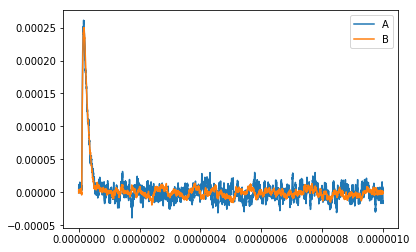

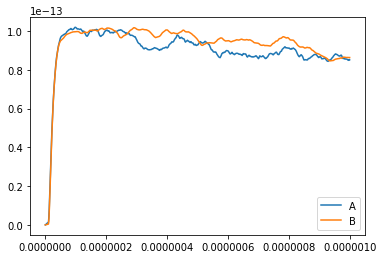

std a at 500 ns: 0.009 pC
std b at 500 ns: 0.009 pC


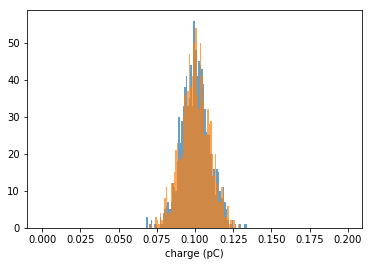

In [8]:
##################################################
##     integral of 1000 pulses after 500 ns     ##
##################################################
Q = 0.1e-12
tau1 = 5e-9
tau2 = 10e-9
delay = 10e-9

det_clean = detector_signal_function(t, Q, tau1, tau2, delay)

mQ500_a = []
mQ500_b = []

noise_bw_a = 100e6
noise_bw_b = 30e6

dt = t[1]-t[0]

index_500ns = int(500e-9/dt)

for i in range(0,1000):
    
  det_a = add_thermal_noise(t,det_clean,R=50,T=300,bw=noise_bw_a)
  det_b = add_thermal_noise(t,det_clean,R=50,T=300,bw=noise_bw_b)
  if(i==0):
    plt.plot(t,det_a,label="A")
    plt.plot(t,det_b,label="B")
    plt.legend()
    plt.show()
  
  
  # integrate current = voltage/50R
  det_int_a = integrate_dt(t,det_a/50)
  det_int_b = integrate_dt(t,det_b/50)
  if(i==0):
    plt.plot(t,det_int_a,label="A")
    plt.plot(t,det_int_b,label="B")
    plt.legend()
    plt.show()
  mQ500_a += [det_int_a[index_500ns]]
  mQ500_b += [det_int_b[index_500ns]]
  

mQ500_a = np.array(mQ500_a)
mQ500_b = np.array(mQ500_b)

bins = np.arange(0.0,0.2,0.001)
plt.hist(mQ500_a*1e12,alpha=0.7,bins=bins)
plt.hist(mQ500_b*1e12,alpha=0.7,bins=bins)
plt.xlabel("charge (pC)")

print("std a at 500 ns: {:3.3f} pC".format(np.std(mQ500_a)*1e12))
print("std b at 500 ns: {:3.3f} pC".format(np.std(mQ500_b)*1e12))



# Explanation

What I meant was: If you have thermal noise and you are interested in the integral after a certain time
it makes no difference if you lowpass filter the signal first to cut off noise contribution from higher bands.
It makes a difference for the smoothness of the direct signal, but it's integral will be exactly the same.
Because lowpass filtering IS integrating, at least above the corner frequency.

# Brown noise (from Wikipedia)

Brown noise can be produced by integrating white noise.[4][5] That is, whereas (digital) white noise can be produced by randomly choosing each sample independently, Brown noise can be produced by adding a random offset to each sample to obtain the next one. A leaky integrator might be used in audio or electromagnetic applications to ensure the signal does not "wander off", that is, exceed the limits of the system's dynamic range. Note that while the first sample is random across the entire dynamic range that the sound sample can take on, the remaining offsets from there on are a tenth or thereabouts, leaving room for the signal to vary randomly within that range.